In [1]:
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
save_dir = '/home/hanna/images_simple_statsmodels/'

In [3]:
files = glob.glob(save_dir + '*ERA5*grid*changes_to_indexes_from*.json')

In [4]:
def get_dict_with_all_keys():
    ex_fil = glob.glob(save_dir + '*ERA5*grid*changes_to_indexes_from*.json')
    merged_dict = {}
    for fil in ex_fil:
        with open(fil, 'r') as f:
            data_grid = json.load(f)
        merged_dict.update(data_grid)   
    return merged_dict

In [5]:
data_grid = get_dict_with_all_keys()

In [6]:
def read_dlon_dlat(save_dir):
    nc_files = glob.glob(save_dir+'*cell*.json')
    print(nc_files)
    
    with open(nc_files[-1]) as f:
        d =  json.load(f)
        
    d_phi      = d['dphi'] 
    d_theta    = d['dtheta'] 
    cell_areas = d['cell_area']
    lat_array  = d['lat'] 
    lon_array  = d['lon']
    #save_dict_to_json(d, "changes_lat_lon_cell-area.json", save_dir = save_dir)
    return d_phi, d_theta, cell_areas, lat_array, lon_array

In [7]:
d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat(save_dir)

['/home/hanna/images_simple_statsmodels/changes_lat_lon_cell-area.json']


In [8]:
ex1 = data_grid['30.25']['19.0']
ex2 = data_grid['30.25']['19.25']
ex3 = data_grid['51.5']['5.75']

In [9]:
ex1.keys()

dict_keys(['centre', 'down', 'up', 'right', 'left', 'corner'])

In [10]:
def plot(lat = '30.25', lon = '19.0'):
    ex1 = data_grid[lat][lon]
    c_lat = [lat_array[i] for i in ex1['corner']['index']]
    c_lon = [lon_array[i] for i in ex1['corner']['index']]
    counter = 0
    for lat, lon in zip(c_lat, c_lon):
        plt.scatter(lat, lon, label = str(counter))
        counter += 1
    plt.scatter(float(lat), float(lon))
    plt.legend()
    return plt.show()

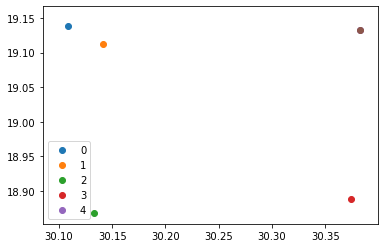

In [11]:
plot(lat = '30.25', lon = '19.0')

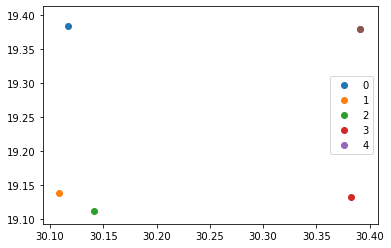

In [12]:
plot(lat = '30.25', lon = '19.25')

In [13]:
lat = '30.25'
lon = '19.25'

ex1 = data_grid[lat][lon]
c_lat = [lat_array[i] for i in ex1['corner']['index']]
c_lon = [lon_array[i] for i in ex1['corner']['index']]

c_lat = ex1['corner']['area']
c_lon = [lon_array[i] for i in ex1['corner']['index']]

In [14]:
p = 0 

for key in ex1.keys():
    #print(key)
    p += np.sum(ex1[key]['area'])
p

105.70627079666626

In [15]:
#l = 0
#for key in ex1.keys():
    #l += np.sum(ex1[key]['area']) * A/p

In [16]:
def area_grid_cell(c_lat, d_lat, d_lon):
        """
        c_lat : float
            Centre point longitude, latitude in degrees

        d_lat, d_lon : float
            delta lat lon in degrees

        Returns : area in km^2

        cdo : If the grid cell area have to be computed it is scaled with the earth radius to square meters.
        """
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return np.abs(area)

In [17]:
c_lat, c_lon

([0.12881826047439884,
  0.02808306606119272,
  0.24591704591857189,
  0.44506775149659017,
  0.04200064654854784],
 [19.383895874023438,
  19.13881492614746,
  19.111848831176758,
  19.13326644897461,
  19.37912940979004])

In [18]:
ex1['corner']['area']

[0.12881826047439884,
 0.02808306606119272,
 0.24591704591857189,
 0.44506775149659017,
 0.04200064654854784]

# Compute distances 

In [19]:
ex1.keys()

dict_keys(['centre', 'down', 'up', 'right', 'left', 'corner'])

In [20]:
def add_small_box(ax, lat, lon, d_lat, d_lon):
    era5_lat = np.linspace(float(lat) - d_lat, float(lat) + d_lat, 100) 
    era5_lon = np.linspace(float(lon) - d_lon, float(lon) + d_lon, 100) 

    ax.plot( era5_lat, np.ones(100)*era5_lon[0])
    ax.plot( era5_lat, np.ones(100)*era5_lon[-1])

    ax.plot( np.ones(100)*era5_lat[0], era5_lon)
    ax.plot(np.ones(100)*era5_lat[-1], era5_lon)
    return ax

In [21]:
def plot_cell(data_grid, lat = '30.25', lon = '19.25'):
    """
    data_grid : dict 
        read file from 
    
    lat : 
    
    lon :
    
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
    ex1 = data_grid[lat][lon]

    for key, item in ex1.items():
        if key != 'centre' and key != 'corner':
            index = item['index']

            lats     = [lat_array[idx] for idx in index]
            #lats_sub = [lats[i] for i in index_sub]

            d_lats    = [d_theta[idx] for idx in index]
            #d_lat_sub = [d_lats[i] for i in index_sub]

            d_lons     = [d_phi[idx] for idx in index]
            #d_lons_sub = [d_lons[i] for i in index_sub]

            lons     = [lon_array[idx] for idx in index]
            #lons_sub = [lons[i] for i in index_sub]

            for i in range(len(d_lats)):
                ax = add_small_box(ax, lats[i], lons[i], d_lats[i], d_lons[i])

            plt.scatter(lats, lons)

        else:
            index = item['index']
            lats  = [lat_array[idx] for idx in index]
            lons  = [lon_array[idx] for idx in index]

            d_lats = [d_theta[idx] for idx in index]
            d_lons = [d_phi[idx] for idx in index]

            for i in range(len(d_lats)):
                ax = add_small_box(ax, lats[i], lons[i], d_lats[i], d_lons[i])

            plt.scatter(lats, lons, s=400, c='b', marker='o', alpha = 0.1)
            plt.legend(item['area'])

    era5_lat = np.linspace(float(lat)-0.25/2, float(lat)+0.25/2, 100) 
    era5_lon = np.linspace(float(lon)-0.25/2, float(lon)+0.25/2, 100) 

    plt.plot( era5_lat, np.ones(100)*era5_lon[0])
    plt.plot( era5_lat, np.ones(100)*era5_lon[-1])

    plt.plot( np.ones(100)*era5_lat[0], era5_lon)
    plt.plot(np.ones(100)*era5_lat[-1], era5_lon)
    plt.show()

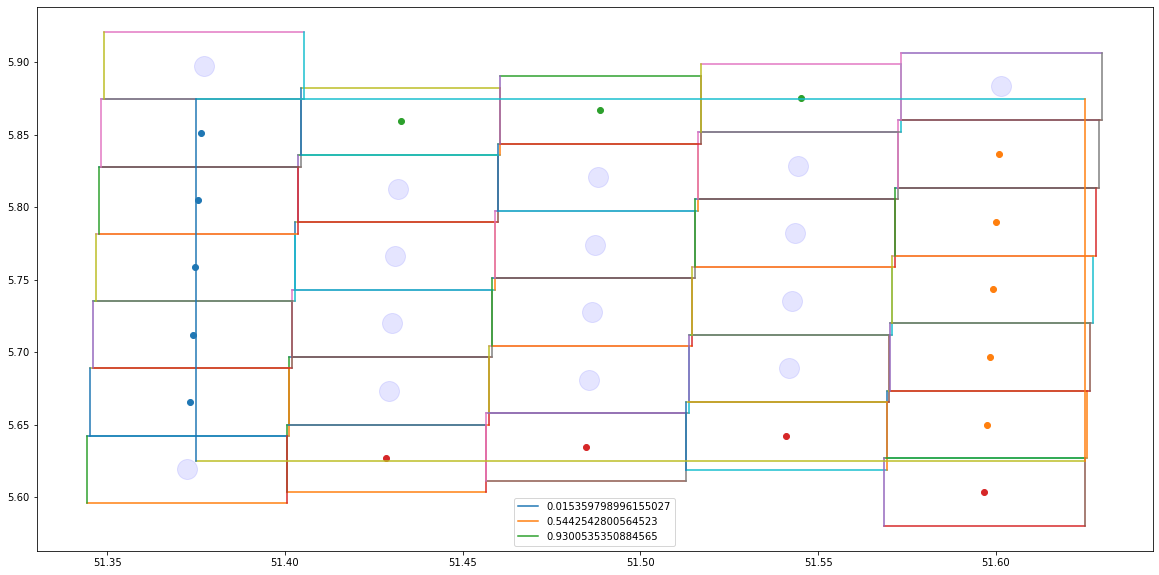

In [22]:
plot_cell(data_grid, lat = '51.5', lon = '5.75')

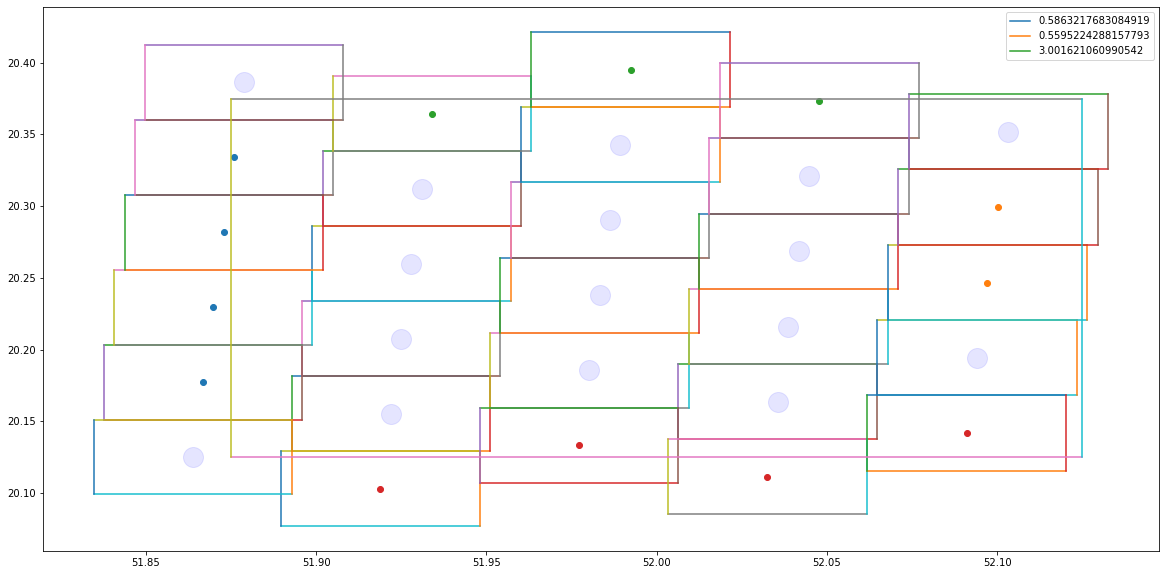

In [23]:
plot_cell(data_grid, lat = '52.0', lon = '20.25')

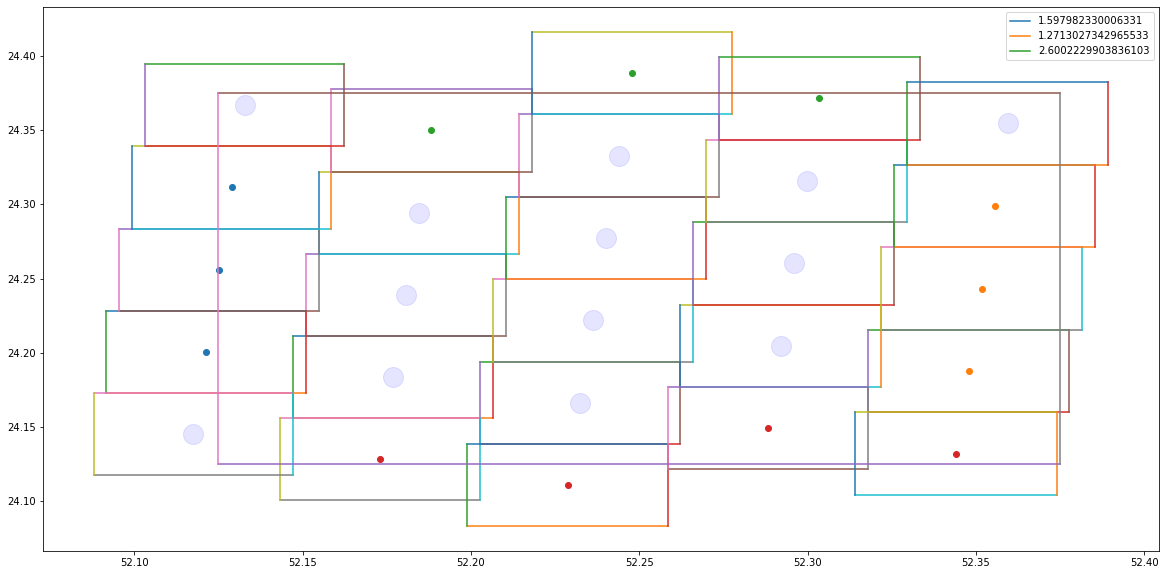

In [24]:
plot_cell(data_grid, lat = '52.25', lon = '24.25')

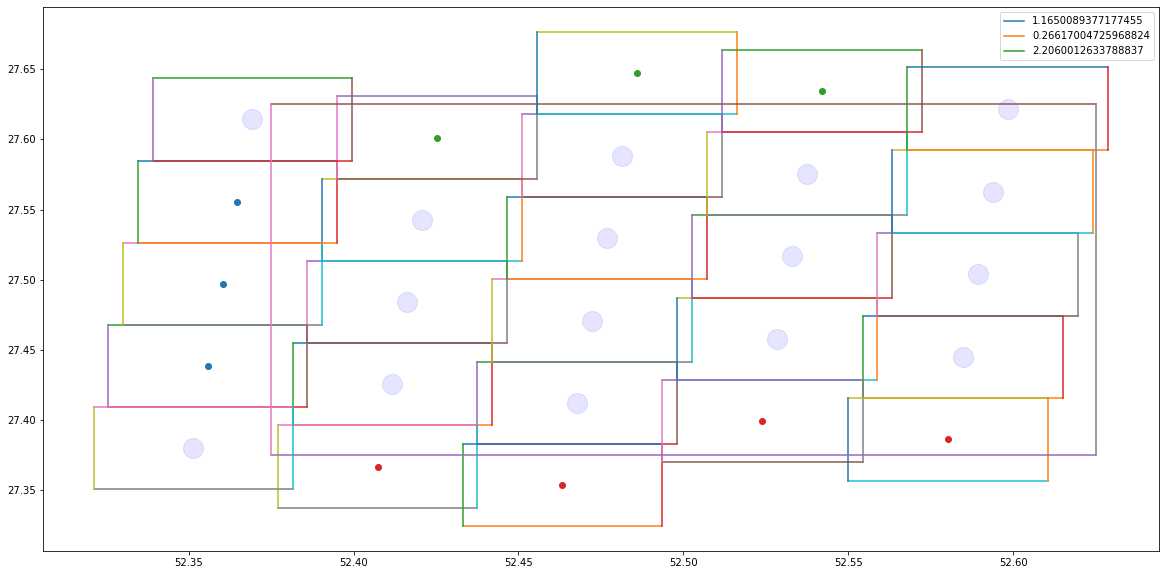

In [25]:
plot_cell(data_grid, lat = '52.5', lon = '27.5')

In [41]:
ex1['corner']['area']/np.max(ex1['centre']['area'])

array([0.06331242, 0.01380244, 0.12086488, 0.21874474, 0.02064364])

In [35]:
np.max(ex1['centre']['area'])

2.034644321165765

In [37]:
ex1['left']['area'], ex1['right']['area']

([0.7147221058417063,
  1.1800600715423395,
  1.6465586894180857,
  0.08687993239935704,
  0.5546515116454263,
  1.0237110183169975],
 [0.029484220787746755,
  1.587630948632793,
  1.1166099074366587,
  0.6443650389673439,
  0.17088541007173266,
  1.7300477404927852,
  1.2553262616965815])

# FIX:

* Doesn't look like the corners get deleted from the subsets 
* Deletes wrong indecies .. Looks like the righmost centres could contain some more data.
* Detect to corners and compute the difference 
    ** If you detect to corner. Does the calculated area overlap or or is it just the individual contributions.
* file that readscloud maska and calculate fraciot

fraction_down = (cloud_mask_array[idx_down_boundary][sub_section_down]*area_grid_cell(lat_down,
                                                                                      dlat_down,
                   
                   dlon_down)).sum()*era_AREA/

In [ ]:
era5_lat = np.linspace(float(lat)-0.25/2, float(lat)+0.25/2, 100) 
era5_lon = np.linspace(float(lon)-0.25/2, float(lon)+0.25/2, 100) 

plt.plot(np.ones(100)*era5_lon[0], era5_lat)
plt.plot(np.ones(100)*era5_lon[-1], era5_lat)

plt.plot(era5_lon, np.ones(100)*era5_lat[0])
plt.plot(era5_lon, np.ones(100)*era5_lat[-1])
#plt.plot(era5_lon)